# Gaussian example

Here we approximate a standard Gaussian target $p(x)=(2\pi)^{-1/2}\exp\left\{-\frac{1}{2}x^2\right\}$ 
with a Gaussian by minimizing both the forward and the reverse KL.
The idea here is that minimizing either divergence should result in the same
approximation: a standard Gaussian! 
This is because the target density is a member of the variational family.

First we import some libraries and then we define relevant code. 

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})
figpath='../doc/fig/'

In [2]:
# gaussian variational approximation
def lq(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*np.log(2*np.pi*sigma**2)

In [3]:
##########################
##########################
#  optimization wrapper  #
##########################
##########################

def gaussianVI(lp,randp,divergence='rev-kl',B=1000,max_iters=1001,lr_mu=1e-2,lr_lsigma=1e-2):
    """
    This function finds an approximation to p 
    by minimizing the divergence from the family of Gaussians
    using stochastic gradient descent (sgd)
    If you want to minimize the reverse KL, randp can be None - it is only used if divergence=='fwd-kl'
    
    Inputs:
        lp         : function, target log pdf
        randp      : function, target random number generator
        divergence : string, one of 'rev-kl' or 'fwd-kl' indicating divergence to minimize
        B          : int, Monte Carlo sample size for gradient estimation
        max_iters  : int, max number of sgd iterations
        lr_mu      : float, sgd learning rate for the mean
        lr_lsigma  : float, sgd learning rate for the log standard deviation
        
    Outputs:
        mus     : (max_iters,) array, all values of the mean through the optimization
        lsigmas : (max_iters,) array, all values of the log sd through the optimization
    """
    
    # initial values
    mus=np.zeros(max_iters+1)
    mus[0]=np.random.randn() # initialize mu at a draw from std normal (cause 0 is probably the opt, let's make it harder)
    lsigmas=np.zeros(max_iters+1)
    lsigmas[0]=np.random.randn() # ditto

    # optimize
    print('Initial μ: '+str(mus[0]))
    print('Initial σ: '+str(np.exp(lsigmas[0])))
    print()
    print('Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient')
    for t in range(max_iters):
        # calculate gradients
        grad_mu=mu_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
        grad_lsigma=ls_gradient(B,mus[t],lsigmas[t],lp,randp,divergence)
    
        # take step
        mus[t+1]=mus[t]-grad_mu*lr_mu/np.sqrt(t+1)
        lsigmas[t+1]=lsigmas[t]-grad_lsigma*lr_lsigma/np.sqrt(t+1)
    
        # do printout
        if t%(max_iters//10)==0: print('  '+str(t)+'   | '+str(mus[t+1])+'   | '+str(np.exp(lsigmas[t+1]))+'   | '+str(grad_mu)+'  | '+str(grad_lsigma))
    # end for
    
    print()
    print('Final μ: '+str(mus[-1]))
    print('Final σ: '+str(np.exp(lsigmas[-1])))
    return mus,lsigmas

##########################
##########################
#       gradients        #
##########################
##########################

def mu_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    # calculate the gradient of the KL w.r.t. the mean mu
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(sample-mu)*np.exp(-2*lsigma))
    if divergence=='fwd-kl':
        sample=randp(B) #~p
        return -np.mean(np.exp(-2*lsigma)*(sample-mu))

def ls_gradient(B,mu,lsigma,lp,randp,divergence='rev-kl'):
    # calculate the gradient of the KL w.r.t. the log sd lsigma
    if divergence=='rev-kl':
        sample=mu+np.exp(lsigma)*np.random.randn(B) #~N(mu,sigma^2)
        return np.mean((lq(sample,mu,lsigma)-lp(sample))*(np.exp(-2*lsigma)*(sample-mu)**2-1.))
    if divergence=='fwd-kl':
        sample=randp(B) #~p
        return -np.mean(np.exp(-2*lsigma)*(sample-mu)**2-1.)
    
    
##########################
##########################
#     auxiliary fns      #
##########################
##########################
def kl(lq,lp,randq,B=1000):
    # estimate KL(q||p)
    # (for fwd KL simply input lp first and supply a randp sampler instead of randq)
    sample=randq(B)
    return np.mean(lq(sample)-lp(sample))

In [4]:
##########################
##########################
#   cauchy target defn   #
##########################
##########################
def lp(x): return lq(x,0.,0.)
def randp(size): return np.random.randn(size)

## Optimization

Here we minimize first the reverse KL and then the forward KL.

In [8]:
##########################
##########################
#    reverse KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=10001
B=10000 # monte carlo sample size for gradient estimation
lr_mu=5*1e-1
lr_lsigma=5*1e-1
divergence='rev-kl'

rev_mus,rev_lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.7073996807616759   | 0.939717297958849   | -1.4070907353467235  | -0.43629137910454485
  1000   | -1.7944019905275794e-14   | 1.0   | -1.849649610787509e-14  | 4.192755408685103e-16
  2000   | -4.591432712444352e-17   | 1.0   | -1.5093459880690782e-18  | 5.117542841176294e-19
  3000   | -2.955521878157905e-17   | 1.0   | -1.7124175658236422e-18  | 7.569951460270165e-20
  4000   | -2.691465113666617e-17   | 1.0   | -1.1084278557850926e-19  | -5.321144057145431e-22
  5000   | -2.607421894291077e-17   | 1.0   | -1.0528347525808909e-19  | 9.675513154079646e-20
  6000   | -2.5310759262481744e-17   | 1.0   | -1.0785409408740778e-19  | 3.1864221955462937e-20
  7000   | -2.4609364114061398e-17   | 1.0   | -9.792697244738977e-20  | -4.3770312680235095e-20
  8000   | -2.3955732864266427e-17   | 1.0   | -1.2116748007781904e-19  | -4.077

In [9]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

rev_mu=rev_mus[-1]
rev_lsigma=rev_lsigmas[-1]

rev_lq = lambda x : lq(x,rev_mu,rev_lsigma)
rev_randq = lambda B : rev_mu+np.exp(rev_lsigma)*np.random.randn(B)

In [14]:
##########################
##########################
#    forward KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=10001
B=10000 # monte carlo sample size for gradient estimation
lr_mu=1e0
lr_lsigma=1e0
divergence='fwd-kl'

fwd_mus,fwd_lsigmas=gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | 1.0537221280214712   | 49.96418495346819   | -2.464667176456509  | -4.191628333187476
  1000   | -0.00034457023124138025   | 0.9979795598269741   | -0.015405098318651608  | -0.009240051936569647
  2000   | -0.0003135603092254359   | 1.0010871918466593   | -0.002574868869650266  | -0.010638589358976444
  3000   | -6.340028519890928e-05   | 0.9993872807329568   | 0.004671139880500944  | -0.012782331335938379
  4000   | -0.00010060743389319593   | 1.0005811473544721   | -0.012333985927656044  | 0.009473817073369722
  5000   | 0.0007689955563339388   | 1.0003784769604682   | -0.004399983718542384  | 0.0168672808411818
  6000   | 0.0010811399117239841   | 1.0013448717360665   | -0.004046419699620404  | 0.009984773987683587
  7000   | 0.0010300252374692124   | 0.9992958911978883   | -0.0041953865779875005  | 0.0018797592442284443
  80

In [15]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

fwd_mu=fwd_mus[-1]
fwd_lsigma=fwd_lsigmas[-1]

fwd_lq = lambda x : lq(x,fwd_mu,fwd_lsigma)
fwd_randq = lambda B : fwd_mu+np.exp(fwd_lsigma)*np.random.randn(B)

## Diagnostics

Now we generate diagnostic plots.
Specifically,
first a logpdf plot comparing the exact target logpdf with both approximations.
Then, a comparison of the credible interval limits for different credibility limits.
Finally, an analysis of the coverage of the intervals as a function of the credibility.

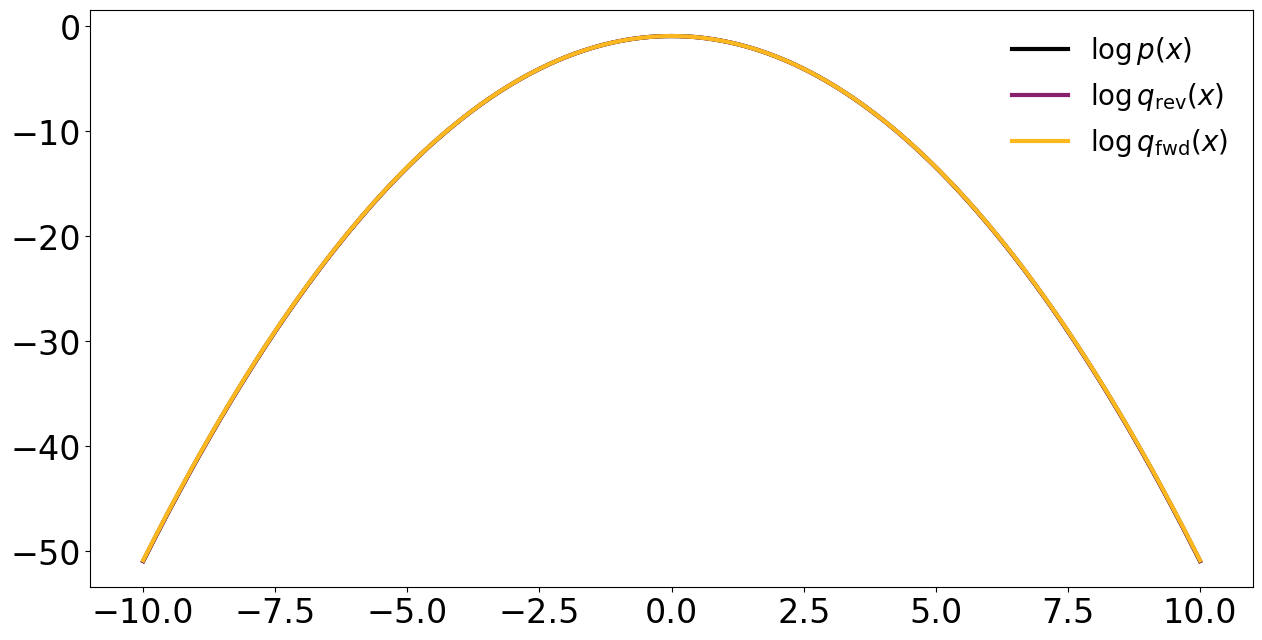

In [17]:
lsx=np.linspace(-10,10,1000)
plt.plot(lsx,lp(lsx),c="black", label=r'$\log p(x)$',lw=3)
plt.plot(lsx,rev_lq(lsx),c='#87216BFF', label=r'$\log q_{\mathrm{rev}}(x)$',lw=3)
plt.plot(lsx,fwd_lq(lsx),c='#FBB91FFF', label=r'$\log q_{\mathrm{fwd}}(x)$',lw=3)
plt.legend(fontsize='small',frameon=False)
plt.savefig(figpath + 'gauss_logq.pdf', dpi=300, bbox_inches='tight')

In [18]:
rev_kl=kl(rev_lq,lp,rev_randq,B=10000)
fwd_kl=kl(lp,fwd_lq,randp,B=10000)
print('Reverse KL: '+str(rev_kl))
print('Forward KL: '+str(fwd_kl))

Reverse KL: 7.771561172376096e-20
Forward KL: 6.937104656379644e-07


### Credible interval comparison

In [21]:
alphas=np.flip(np.linspace(0.01,0.2,101)[1:])
true_lims=stats.norm.ppf(1-alphas/2)
rev_lims=stats.norm.ppf(1-alphas/2,loc=rev_mu,scale=np.exp(rev_lsigma))
fwd_lims=stats.norm.ppf(1-alphas/2,loc=fwd_mu,scale=np.exp(fwd_lsigma))

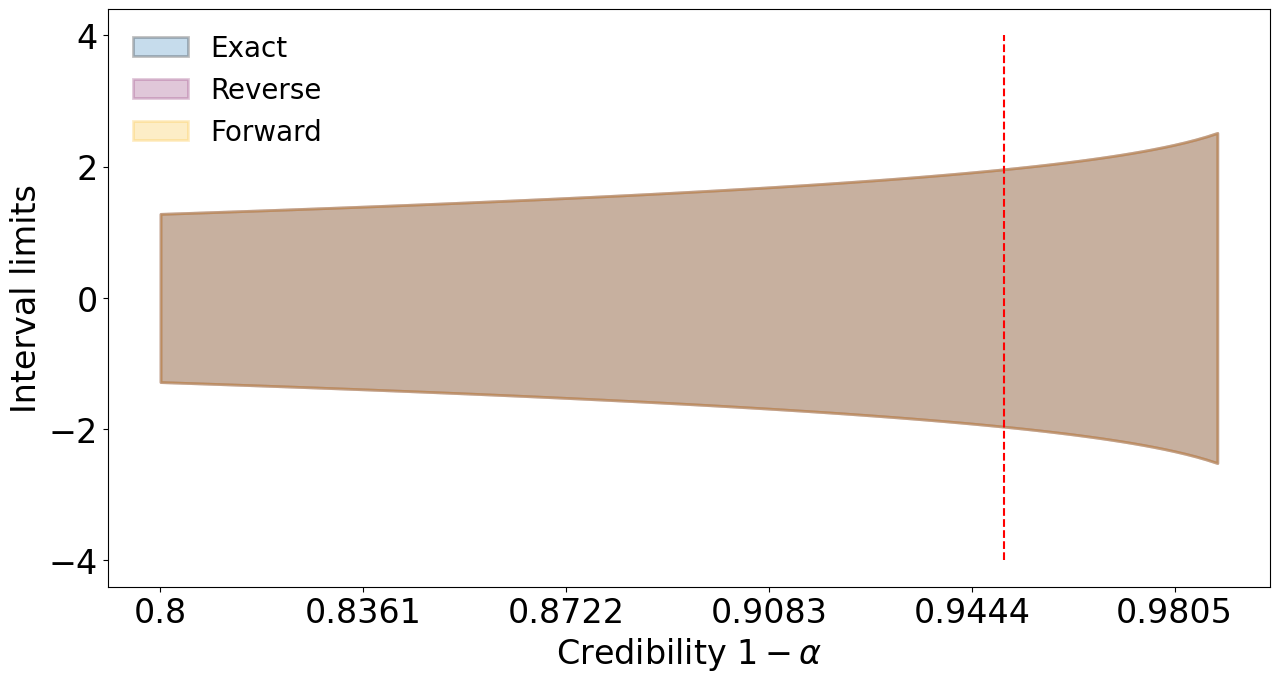

In [24]:
lsa=np.arange(0,alphas.shape[0])
#plt.errorbar(x=lsa,y=np.zeros(alphas.shape[0]),yerr=true_lims[1,:])
plt.fill_between(x=lsa,y1=true_lims,y2=-true_lims,label='Exact',alpha=0.25,ec='black',lw=2)
plt.fill_between(x=lsa,y1=rev_lims,y2=-rev_lims,label='Reverse',alpha=0.25,ec='black',lw=2,color='#87216BFF')
plt.fill_between(x=lsa,y1=fwd_lims,y2=-fwd_lims,label='Forward',alpha=0.25,ec='black',lw=2,color='#FBB91FFF')
plt.vlines(np.argmax(alphas==0.0499),-4,4,ls='dashed',color='red')

plt.ylabel('Interval limits')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');
plt.savefig(figpath + 'gauss_cilims.pdf', dpi=300, bbox_inches='tight')

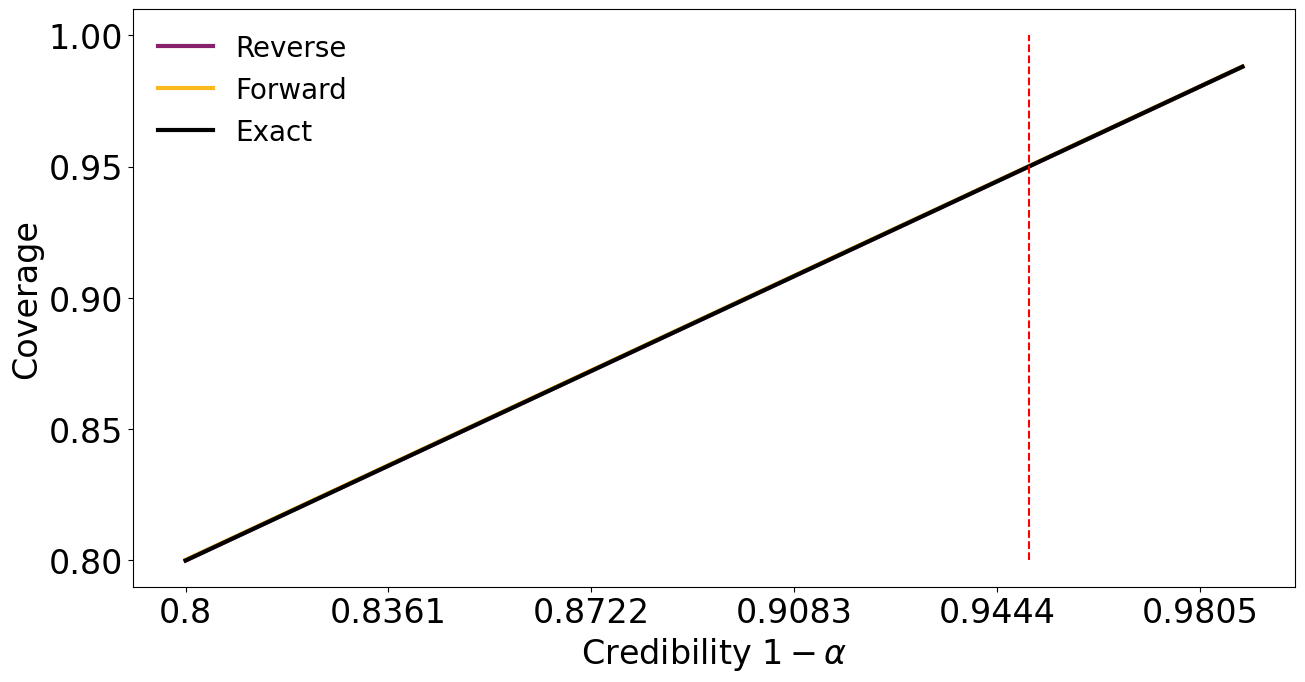

In [28]:
plt.plot(lsa,1-2*stats.norm.sf(rev_lims),label='Reverse',lw=3,color='#87216BFF')
plt.plot(lsa,1-2*stats.norm.sf(fwd_lims),label='Forward',lw=3,color='#FBB91FFF')
plt.plot(lsa,1-alphas[lsa],label='Exact',lw=3,color='black')
plt.vlines(np.argmax(alphas==0.0499),0.8,1,ls='dashed',color='red')

plt.ylabel(r'Coverage')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');
plt.savefig(figpath + 'gauss_cicoverage.pdf', dpi=300, bbox_inches='tight')

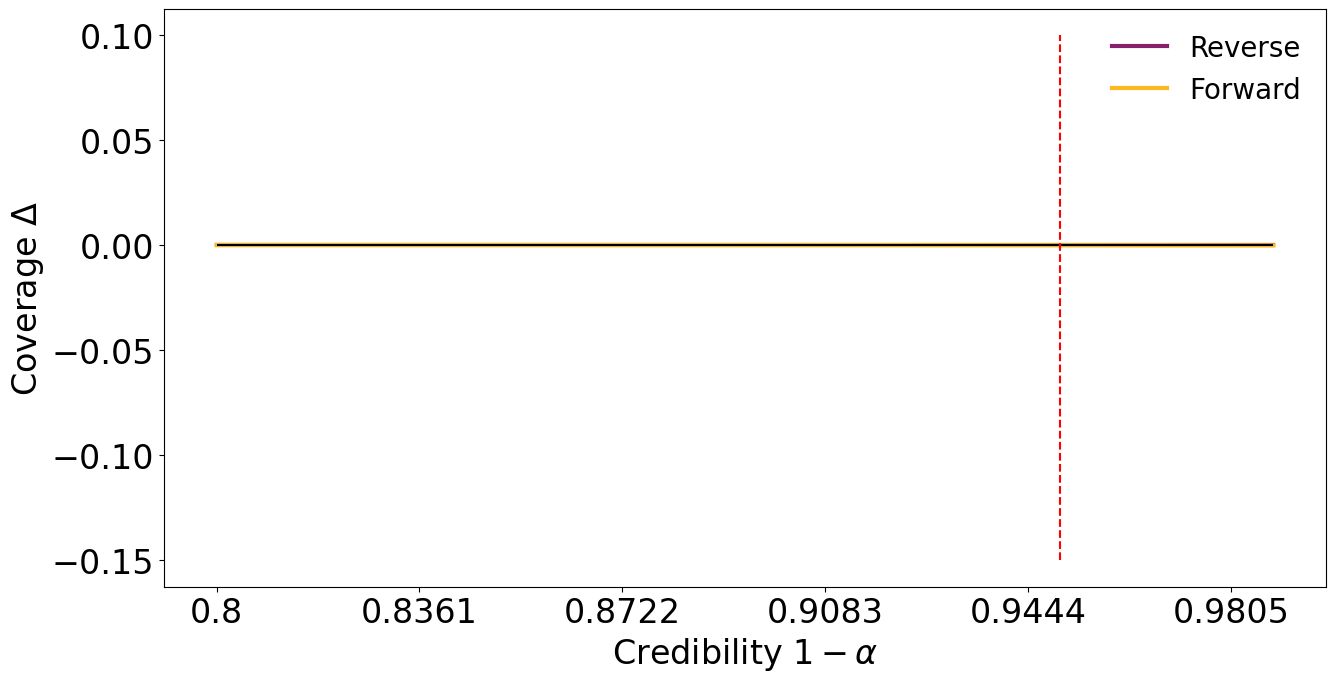

In [27]:
plt.plot(lsa,alphas-2*stats.norm.sf(rev_lims),label='Reverse',lw=3,color='#87216BFF')
plt.plot(lsa,alphas-2*stats.norm.sf(fwd_lims),label='Forward',lw=3,color='#FBB91FFF')
plt.hlines(0,lsa[0],lsa[-1],color='black')
plt.vlines(np.argmax(alphas==0.0499),-0.15,0.1,ls='dashed',color='red')

plt.ylabel(r'Coverage $\Delta$')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper right');